# MODEL EVALUATION

This file has been placed in `archive` because it was only used once. This script first parses the `example_transcripts` and saves all questions to `question_datasets/all_questions_unlabeled.csv`. 

It then selects a subset of questions (by embedding, clustering, and sampling from each cluster) to populate a training set for manual labeling. I manually labeled these 1000 questions, creating `labeled_training_questions.csv`. 

Finally, it evaluates the performance of a set of models from HuggingFace on the labeled training set, which I used to select the final model.

This cannot be run on the `hcrc_env` because it uses some packages not included. 

In [1]:
%conda activate lab # using a different environment with more of the necessary libraries


Note: you may need to restart the kernel to use updated packages.



ArgumentError: activate does not accept more than one argument:
['lab', '#', 'using', 'a', 'different', 'environment', 'with', 'more', 'of', 'the', 'necessary', 'libraries']




### Create labeled question set

In [ ]:
#### SAVE ALL QUESTIONS TO CSV

import pandas as pd

# split this process into ranges of lines corresponding to each witness (to parallelize for speed)
# def process_one_range(range_of_lines, lines):
# initialize variables to be used as we loop
current_witness = ''
current_witness_side = ''
current_examination = ''
current_examiner = ''
qdata = pd.DataFrame(columns=['row_i', 'question_text', 'answer_yes_no', 'gpt_yes_no'])

queries_to_make = []

for i in range(len(lines)):
    line = lines[i]

    if line_is_witness_identifier(lines, i):
        current_witness = clean_simple_line(line)
        current_witness_side = who_presents_this_witness(lines, i)

    elif line_is_examination_identifier(lines, i):
        current_examiner = ''
        current_examination = clean_simple_line(line)

    elif line_is_examiner_identifier(line):
        current_examiner = clean_examiner_name(line)

    elif is_answer(line):
        # we may need to guess necessary preceding info if there was an error in pdf reading
        if current_examiner == '': 
            current_examiner = guess_examiner(current_witness_side, current_examination) 

        active_question = guess_previous_question(lines, i, current_examiner) 
            
        if '?' in active_question: # to rule out things like "Q. Good morning."
            yes_no_answer = is_yes_no_answer(lines, i, current_examiner)
            # yes_no_question = True if yes_no_answer=='yes' else is_yes_no(clean_question(active_question))
            if yes_no_answer!='yes': queries_to_make.append((i, clean_question(active_question)))

            yes_no_answer_tag = 'Y' if yes_no_answer=='yes' else 'n'
            yes_no_question_tag = '' # 'Y' if yes_no_question else 'n'

            qdata.loc[len(qdata)] = [i, clean_question(active_question), yes_no_answer_tag, yes_no_question_tag]
    elif active_question:
        active_question += line # if we started a question, add this line. resets at every answer or special identifying line

print('queries to make: ', len(queries_to_make))
qdata.to_csv('question_datasets/all_questions_unlabeled.csv', index=False)

# def run(arg):
#     i, question = arg
#     return i, is_yes_no(question)
# with ThreadPoolExecutor(max_workers=128) as executor:
#     results = list(executor.map(run, queries_to_make))

# for i,gpt_out in results:
#     out = 'Y' if gpt_out else 'n'
#     qdata.loc[i, 'gpt_yes_no'] = out
# qdata.to_csv('all_questions_unlabeled.csv', index=False)

In [ ]:
# sentence embedding
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

df = pd.read_csv('/Users/ciyer/Documents/yn_transcript/all_questions_unlabeled.csv')
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(df['question_text'].tolist())
normalized_embeddings = normalize(embeddings)

In [ ]:
# PCA
pca = PCA()
pca_result = pca.fit_transform(embeddings)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()

In [ ]:
# 50-means clustering and save output
n_clusters = 50 # elbow-ish of the PCA curve
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(normalized_embeddings)

df['cluster'] = cluster_labels

# Function to sample from each cluster
def sample_from_cluster(cluster_id, n_samples=20):
    cluster_indices = df[df['cluster'] == cluster_id].index
    if len(cluster_indices) <= n_samples:
        return cluster_indices
    else:
        return np.random.choice(cluster_indices, n_samples, replace=False)

# Sample 20 sentences from each cluster
sampled_indices = []
for i in range(n_clusters):
    sampled_indices.extend(sample_from_cluster(i))

# Convert to list if it's not already
sampled_indices = list(sampled_indices)

# Shuffle the sampled indices
np.random.shuffle(sampled_indices)

# Ensure we have exactly 1000 samples
if len(sampled_indices) > 1000:
    sampled_indices = sampled_indices[:1000]

df.loc[sampled_indices,].drop('cluster', axis=1).to_csv('/Users/ciyer/Documents/yn_transcript/training_questions.csv', index=False)

### MODEL EVALUATION

Starting model:  gpt
Model: gpt_yes_no, Accuracy: 0.7016


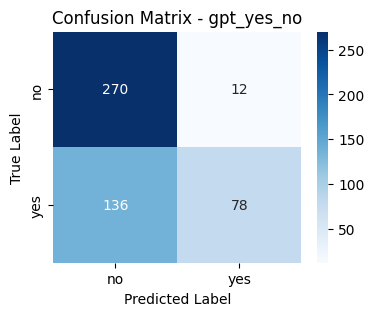

Starting model:  facebook/bart-large-mnli


KeyboardInterrupt: 

In [1]:
import pandas as pd
from transformers import pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/ciyer/Documents/yn_transcript/question_datasets/labeled_training_questions.csv')
train_data = df[df.answer_yes_no == 'no'].copy()

models = {
    'gpt': {'pipeline': ''},
    "facebook/bart-large-mnli": {'yes/no question': 'yes', 'other question': 'no', 'pipeline': 'zero-shot-classification'},
    "scott-routledge/bert-question-classifier": {'LABEL_0': 'yes', 'LABEL_1': 'no', 'LABEL_2': 'yes', 'pipeline': 'text-classification'},
    "sophiaqho/question_classifier_model_v2": {'LABEL_0': 'yes', 'LABEL_1': 'no', 'pipeline': 'text-classification'},
    "alangpp255/Question_classifier_V2": {'TF': 'yes', 'WH': 'no', 'pipeline': 'text-classification'},
    "ndavid/binary-question-classifier-bert": {'LABEL_0': 'no', 'LABEL_1': 'yes', 'pipeline': 'text-classification'},
    "PrimeQA/tydi-boolean_question_classifier-xlmr_large-20221117": {'LABEL_0': 'yes', 'LABEL_1': 'no', 'pipeline': 'text-classification'},
    "PrimeQA/tydiqa-boolean-question-classifier": {'LABEL_0': 'no', 'LABEL_1': 'yes', 'pipeline': 'text-classification'}
}

def add_model_preds(model_name, train_data):
    pipe = models[model_name]['pipeline']
    classifier = pipeline(pipe, model=model_name)
    if pipe == 'zero-shot-classification':
        candidate_labels = ["yes/no question", "other question"]
        results = classifier(train_data['question_text'].tolist(), candidate_labels)
        results = [r['labels'][0] for r in results]
    elif pipe == 'text-classification':
        results = [classifier(q)[0]['label'] for q in train_data.question_text]

    predicted_labels = [models[model_name][p] for p in results]
    train_data[model_name] = predicted_labels

def evaluate_model(model_name, train_data):
    print('Starting model: ', model_name)
    
    if model_name == 'gpt': model_name = 'gpt_yes_no'
    if model_name not in train_data.columns:
        add_model_preds(model_name, train_data)

    accuracy = accuracy_score(train_data['manual_yes_no'], train_data[model_name])
    cm = confusion_matrix(train_data['manual_yes_no'], train_data[model_name], labels=['no','yes'])

    print(f"Model: {model_name}, Accuracy: {accuracy:.4f}")
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no','yes'], yticklabels=['no','yes'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


for model_name in models.keys():
    evaluate_model(model_name, train_data)

train_data.to_csv('labeled_training_set_model_predictions.csv', index=False)